# Exercice 3

Nous avons fait un modèle utilisant spacy pour le traitement de données et un SVM pour la classification. 

> Nous avions mis une forte emphase sur l’importance de la précision du modèle. La différence par rapport au modèle précédent n’est pas importante, au contraire même. Si nous considérons la moyenne pondérée, nous avons une baisse de la précision et une augmentation du recall et du f1-score.






In [ ]:
#IMPORTS
#!pip install -r requirements.txt

import spacy
import sklearn
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
!pip install scikit-plot
import scikitplot as skplt
import os

In [ ]:
# Chargement des données
os.system("!pip install -U spacy")

#LOAD DATASET
with open("training_set.json", "r",encoding="utf-8") as dataset_file:
   training_set = json.load(dataset_file)

with open("testing_set.json", "r",encoding="utf-8") as dataset_file:
   testing_set = json.load(dataset_file)
   sentences_train, labels_train, sentences_test, labels_test= [], [], [], []

# On prend les sets, on divise en deux set séparé (la phrase et l'intention)
for i in range(len(training_set)):
   sentences_train.append(training_set[i].get("sentence"))
   labels_train.append(training_set[i].get("intent"))

for i in range(len(testing_set)):
   sentences_test.append(testing_set[i].get("sentence"))
   labels_test.append(testing_set[i].get("intent"))

In [ ]:
# Préparation des données pour l'entrainement et le test
os.system('python -m spacy download fr_core_news_md')
nlp = spacy.load('fr_core_news_md')


embedding_dim = nlp.vocab.vectors_length

def encode_sentences(sentences):
   n_sentences = len(sentences)
   X = np.zeros((n_sentences, embedding_dim))
   for idx, sentence in enumerate(sentences):
      doc = nlp(sentence)
      X[idx, :] = doc.vector
   return X

def label_encoding(labels):
   n_labels = len(labels)
   from sklearn.preprocessing import LabelEncoder
   le = LabelEncoder()
   y =le.fit_transform(labels)
   return y

train_X, train_y = encode_sentences(sentences_train), label_encoding(labels_train)
test_X, test_y = encode_sentences(sentences_test), label_encoding(labels_test)

In [ ]:
# On entraine le modèle SVC

def svc_training(X,y):
    clf = SVC(C=1, probability= True)
    clf.fit(X, y)
    return clf

model = svc_training(train_X,train_y)

In [ ]:
#Validation du modèle
# model2 = svc_training(train_X, train_y, probability = True)
probas = model.predict_proba(test_X)
def svc_validation(model,X,y):
    y_pred = model.predict(X)
    n_correct = 0
    for i in range(len(y)):
        if y_pred[i] == y[i]:
            n_correct += 1

    print("Predicted {0} correctly out of {1} examples".format(n_correct, len(y)))

svc_validation(model,train_X,train_y)
svc_validation(model,test_X,test_y)

Predicted 5073 correctly out of 6035 examples
Predicted 827 correctly out of 1065 examples


# Etude des Métriques

## Accuracy
Nous avons une baisse de l’accuracy, mais encore une fois, au vu du déséquilibre du dataset, nous ne pouvons rien tirer de l’information.

In [ ]:
# accuracy des données testées
accuracy = 0
for i in range(len(y_pred)):
    accuracy += (y_pred[i]==train_y[i])
accuracy = accuracy / len(y_pred)
print("Accuracy du modèle : " ,  accuracy)

Accuracy du modèle :  0.5145539906103287


## Matrice de confusion
Nous remarquons que notre matrice de confusion souligne un meilleur modèle en termes d'efficacité et de précision. En effet, à une exception près, les valeurs centrales, représentant les prédictions correctes, sont plus grandes. Nous notons que la classe 5, représentant la classe plus imposante, celle des "irrelevants", continue à “aspirer” les prédictions, mais avec une moins grande force que précédemment. Ce qui ne nous dérange pas. En effet, irrelevant aurait mené au contact d’un humain plutôt qu’une réponse par chatbot, ce qui est acceptable.
Nous remarquons quand même que les demandes auxquelles on a mal répondu (donc autre que 5), se valent;

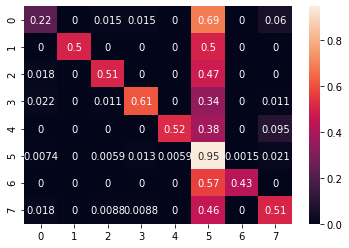

In [ ]:
# matrice de confusion
conf_mat= sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(conf_mat, annot=True)
plt.show()

## F1, FBeta, Kappa
Nous avons donc une augmentation globale du score F1. Ce qui n’est pas un bon signe, comme nous le disions dans la question 1.
Du côté de F-Beta, nous notons cette fois une légère amélioration globale, ce qui cette fois, nous satisfait.
Pour le Kappa de Cohen, nous avons une augmentation nette. Ce qui signifie une plus forte fiabilité du modèle.

In [ ]:
# f1, f_beta, kappa
f1 = sklearn.metrics.f1_score(y_true, y_pred, zero_division=1, average=None)
fb = sklearn.metrics.fbeta_score(y_true, y_pred, beta= 0.1, zero_division=1, average=None)
kappa = sklearn.metrics.cohen_kappa_score(y_true, y_pred,sample_weight=None)

print("F1- Score : \n\n", f1, "\n")
print("Fβ- Score pour β=0.1 :\n\n ", fb, "\n")
print("Kappa de Cohen : ", kappa)

F1- Score : 

 [0.32608696 0.66666667 0.62222222 0.70807453 0.61111111 0.85276482
 0.57142857 0.60103627] 

Fβ- Score pour β=0.1 :

  [0.59018309 0.99019608 0.7954993  0.83519513 0.7304405  0.77807335
 0.8487395  0.7309708 ] 

Kappa de Cohen :  0.544729553512733


## Roc Curve

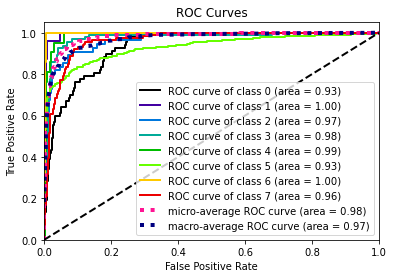

In [ ]:
skplt.metrics.plot_roc(y_true, probas)
plt.legend(loc="lower right")

plt.show()

## Precision, Recall, F1

Nous avions mis une forte emphase sur l’importance de la précision du modèle. La différence par rapport au modèle précédent n’est pas importante, au contraire même. Si nous considérons la moyenne pondérée, nous avons une baisse de la précision. et une augmentation du recall et du f1-score.

In [ ]:
# Precision, Recall, F1
from sklearn.metrics import classification_report
y_true, y_pred = test_y, model.predict(test_X)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.22      0.33        67
           1       1.00      0.50      0.67        24
           2       0.80      0.51      0.62        55
           3       0.84      0.61      0.71        93
           4       0.73      0.52      0.61        21
           5       0.78      0.95      0.85       677
           6       0.86      0.43      0.57        14
           7       0.73      0.51      0.60       114

    accuracy                           0.78      1065
   macro avg       0.79      0.53      0.62      1065
weighted avg       0.77      0.78      0.76      1065



## Exercices 4-5
Du à des problèmes avec DockerHub, nous n'avons pas pu les finir, mais nous réessayerons dans la semaine.